In [11]:
from vae import cvae
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


In [12]:
# load data
from torch.utils.data import DataLoader, TensorDataset
from vae.cvae import VAEFeaturizer

d2_path = './VAE_data/d2_Klek_clean.csv'
ht1a_path = './VAE_data/5ht1a_Klek_clean.csv'
ht7_path = './VAE_data/5ht7_Klek_clean.csv'
beta2_path = './VAE_data/beta2_Klek_clean.csv'
h1_path = './VAE_data/h1_Klek_clean.csv'

df = pd.read_csv(d2_path)
df = df.dropna()

featurizer = cvae.VAEFeaturizer()
fp_train, ki_train = featurizer(df)

fp_train = torch.from_numpy(fp_train).to(device)
ki_train = torch.from_numpy(ki_train).to(device)

# define dataset

tensor_ds = TensorDataset(fp_train, ki_train)
train_dataloader = DataLoader(tensor_ds, batch_size=64, shuffle=True)

### CVAE

In [13]:
# define parameters

latent_size = 8
input_size = fp_train.shape[1]
learning_rate = 0.0003

# init model

model = cvae.CVAE(input_size=input_size, latent_size=latent_size).to(device)

In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

def train_CVAE(model, train_dataloader, learning_rate, epochs=40, device=device, plot_loss=False):
    
    criterion = cvae.VAELoss()
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    sheduler = ReduceLROnPlateau(optimizer, 'min', patience=25, verbose=True)
    losses = []
    
    if plot_loss:
        fig, ax = plt.subplots()
        dh = display(fig, display_id=True)

    for epoch in tqdm(range(1, epochs+1)):
        for (fp, y) in train_dataloader:
            if device == 'cuda':
                fp = fp.cuda()
                y = y.cuda()
            encoded, mu, logvar = model(fp, y)
            loss = criterion(encoded, fp, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        sheduler.step(loss)
        losses.append(loss.item())
        if plot_loss:
            ax.clear()
            ax.plot(losses)
            ax.set_title(f'Epoch {epoch}, Loss: {loss.item():.2f}')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.set_yscale('log')
            dh.update(fig)
            
    return model, losses

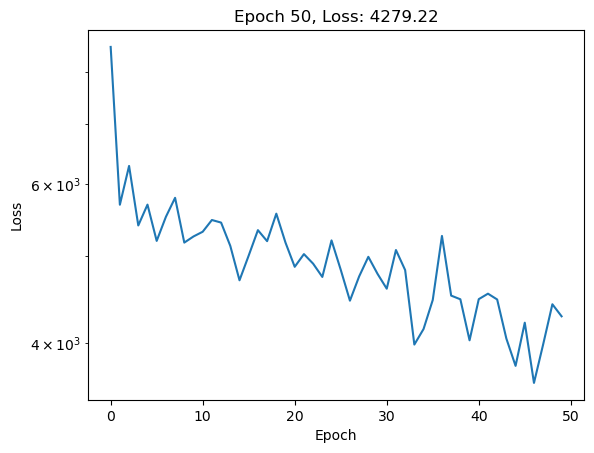

  0%|          | 0/50 [00:00<?, ?it/s]

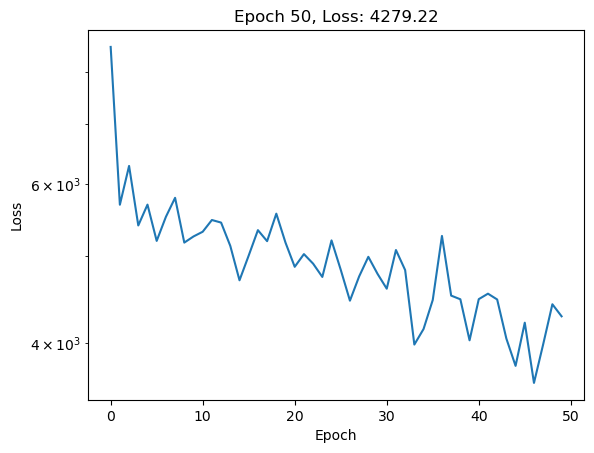

In [15]:
cvae, losses = train_CVAE(model, train_dataloader, learning_rate, 
                          epochs=50, device=device, plot_loss=True)

In [16]:
# encode all data into latent space

encoded_cvae = []
for (fp, y) in train_dataloader:
    fp = fp.to(device)
    y = y.to(device)
    mu, logvar = cvae.encoder(fp, y)
    enc = cvae.reparameterize(mu, logvar)
    encoded_cvae.append(enc.detach().cpu().numpy())

In [20]:
from sklearn.decomposition import PCA

# plot PCA

cvae_pca = PCA(n_components=2)
cvae_pca_results = cvae_pca.fit_transform(np.concatenate(encoded_cvae))
cvae_pca_results = pd.DataFrame(cvae_pca_results)
cvae_pca_results['activity'] = activity

sns.set_style('whitegrid')
colors = ['#D3D3D3', '#880808']
sns.scatterplot(x=0, y=1, hue='activity', data=cvae_pca_results, marker='.', palette=colors)
plt.title('CVAE PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')

NameError: name 'activity' is not defined

In [19]:
# plot t-SNE

cvae_tsne = TSNE(n_components=2, perplexity=20, learning_rate=100)
cvae_tsne_results = cvae_tsne.fit_transform(np.concatenate(encoded_cvae))
cvae_tsne_results = pd.DataFrame(cvae_tsne_results)
cvae_tsne_results['activity'] = activity

sns.set_style('whitegrid')
colors = ['#D3D3D3', '#880808']
sns.scatterplot(x=0, y=1, hue='activity', data=cvae_tsne_results, marker='.', palette=colors)
plt.title('CVAE t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

NameError: name 'TSNE' is not defined

In [2]:
from vae.cvae import sample_CVAE

In [17]:
artificial_active = sample_CVAE(model=cvae, n_samples=100, device=device, active=True)

# convert to binary
artificial_active[artificial_active >= 0.5] = 1
artificial_active[artificial_active < 0.5] = 0

real_active = fp_train[activity == 1].detach().cpu().numpy()
real_active_bits = np.where(real_active == 1)[1]
artificial_active_bits = np.where(artificial_active == 1)[1]

# compare top 10 most frequent bits
from collections import Counter
real_active_freq = Counter(real_active_bits)
artificial_active_freq = Counter(artificial_active_bits)
print('Bits in top 10 most frequent bits:')
print(f'real_active bits: {real_active_freq.most_common(10)}')
print(f'artificial_active bits: {artificial_active_freq.most_common(10)}')

NameError: name 'activity' is not defined

In [77]:
artificial_in_real = {k:v/2752 for k,v in real_active_freq.items() if k in artificial_active_freq.keys()}
artificial_active_freq = {k:v/100 for k,v in artificial_active_freq.items()}

In [78]:
artificial_in_real = {k:v for k,v in sorted(artificial_in_real.items(), key=lambda x: x[0])}
artificial_active_freq = {k:v for k,v in sorted(artificial_active_freq.items(), key=lambda x: x[0])}

In [79]:
artificial_in_real

{0: 1.0,
 2: 0.918968023255814,
 10: 0.08539244186046512,
 16: 0.43059593023255816,
 20: 0.9422238372093024,
 23: 0.9411337209302325,
 27: 0.4251453488372093,
 38: 0.08284883720930232,
 58: 0.5007267441860465,
 61: 0.23873546511627908,
 75: 0.36700581395348836,
 87: 0.2903343023255814,
 88: 0.21329941860465115,
 94: 0.26453488372093026,
 97: 0.44040697674418605,
 113: 0.9916424418604651,
 114: 0.9665697674418605,
 124: 0.5661337209302325,
 129: 1.0,
 134: 1.0,
 135: 1.0,
 136: 0.9811046511627907,
 138: 1.0}

In [82]:
df = pd.DataFrame()
df['bit'] = artificial_in_real.keys()
df['artificial_freq'] = artificial_in_real.values()
df['real_freq'] = artificial_active_freq.values()
df['difference'] = df['artificial_freq'] - df['real_freq']
df.head()

,bit,artificial_freq,real_freq,difference
0,0,1.000000,1.00,0.000000
1,2,0.918968,1.00,-0.081032
2,10,0.085392,0.01,0.075392
3,16,0.430596,0.20,0.230596
4,20,0.942224,1.00,-0.057776


In [91]:
df['bit'] = df['bit'].astype('category')
df.describe()

,artificial_freq,real_freq,difference
count,23.000000,23.000000,23.000000
mean,0.636817,0.565652,0.071165
std,0.350832,0.439812,0.106326
min,0.082849,0.010000,-0.081032
25%,0.328670,0.130000,-0.004179
50%,0.566134,0.490000,0.052849
75%,0.986374,1.000000,0.162936
max,1.000000,1.000000,0.254535


In [106]:
alt_df = pd.melt(df, id_vars=['bit'], value_vars=['artificial_freq', 'real_freq'], var_name='type', value_name='frequency')
alt_df

,bit,type,frequency
0,0,artificial_freq,1.000000
1,2,artificial_freq,0.918968
2,10,artificial_freq,0.085392
3,16,artificial_freq,0.430596
4,20,artificial_freq,0.942224
5,23,artificial_freq,0.941134
6,27,artificial_freq,0.425145
7,38,artificial_freq,0.082849
8,58,artificial_freq,0.500727
9,61,artificial_freq,0.238735


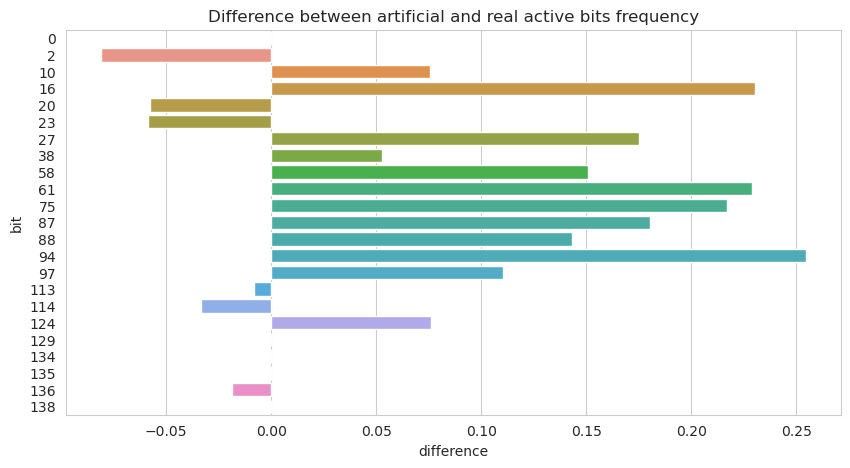

In [95]:
# create twoside vertical barplot
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='difference', y='bit', data=df, ax=ax)
ax.title.set_text('Difference between artificial and real active bits frequency')

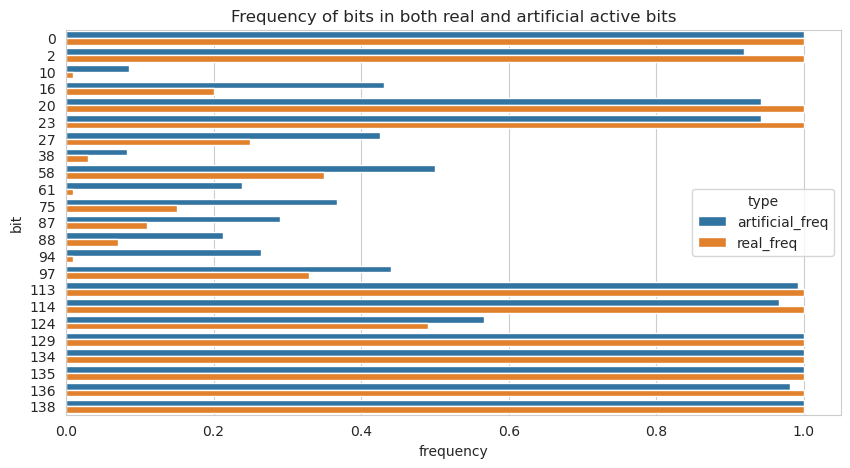

In [109]:
# plot frequency of bits in both real and artificial active bits one next to another
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(y='bit', x='frequency', hue='type', data=alt_df, ax=ax)
ax.title.set_text('Frequency of bits in both real and artificial active bits')
